# This notebook is used to test the Tentacle class without Orchestrator in a sim environment.

### Utility Classes (Robot, PI Controller), etc.


In [1]:
import time
import numpy as np
import warnings
from matplotlib import pyplot as plt
from matplotlib.patches import Arrow
from IPython import display
import threading
import random


###################################################### Class Definitions ######################################################

# Used to implement smoothing dt. Lower alpha means less smoothing, faster response to changes
class ExponentialMovingAverage:
    def __init__(self, alpha):
        self.alpha = alpha
        self.value = None

    def update(self, new_value):
        if self.value is None:
            self.value = new_value
        else:
            self.value = (1 - self.alpha) * new_value + self.alpha * self.value
        return self.value
    

# Used to implement velocity smoothing. Lower tau means less smoothing, faster response to changes.
class LowPassFilter:
    def __init__(self, tau):
        self.tau = tau
        self.previous_value = None
        self._last_smoothed_value = None

    def update(self, new_value, dt):
        if self.previous_value is None:
            self.previous_value = new_value
            self._last_smoothed_value = new_value
        else:
            alpha = dt / (self.tau + dt)
            self._last_smoothed_value = alpha * new_value + (1 - alpha) * self.previous_value
            self.previous_value = self._last_smoothed_value
        return self._last_smoothed_value

    @property
    def value(self):
        if self._last_smoothed_value is None:
            return 0
        return self._last_smoothed_value
    
class DiffDriveRobot:
    
    def __init__(self,inertia=5, dt=0.1, drag=0.2, wheel_radius=0.05, wheel_sep=0.15):
        
        self.x = 0.0 # y-position
        self.y = 0.0 # y-position 
        self.th = 0.0 # orientation
        
        self.wl = 0.0 #rotational velocity left wheel
        self.wr = 0.0 #rotational velocity right wheel
        
        self.I = inertia
        self.d = drag
        self.dt = dt
        
        self.r = wheel_radius
        self.l = wheel_sep
    
    # Should be replaced by motor encoder measurement which measures how fast wheel is turning
    # Here, we simulate the real system and measurement
    def motor_simulator(self,w,duty_cycle):
        
        torque = self.I*duty_cycle
        
        if (w > 0):
            w = min(w + self.dt*(torque - self.d*w),3)
        elif (w < 0):
            w = max(w + self.dt*(torque - self.d*w),-3)
        else:
            w = w + self.dt*(torque)
        
        return w
    
    # Veclocity motion model
    def base_velocity(self,wl,wr):
        
        v = (wl*self.r + wr*self.r)/2.0
        
        w = (wl*self.r - wr*self.r)/self.l
        
        return v, w
    
    # Kinematic motion model
    def pose_update(self,duty_cycle_l,duty_cycle_r):
        
        self.wl = self.motor_simulator(self.wl,duty_cycle_l)
        self.wr = self.motor_simulator(self.wr,duty_cycle_r)
        
        v, w = self.base_velocity(self.wl,self.wr)
        
        self.x = self.x + self.dt*v*np.cos(self.th)
        self.y = self.y + self.dt*v*np.sin(self.th)
        self.th = self.th + w*self.dt
        
        return self.x, self.y, self.th
    
    @property
    def pose(self):
        return self.x, self.y, self.th
    
    
class RobotController:
    
    def __init__(self,Kp=0.1,Ki=0.01,wheel_radius=0.02, wheel_sep=0.1):
        
        self.Kp = Kp
        self.Ki = Ki
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        
    def p_control(self,w_desired,w_measured,e_sum):
        print(f"desired: {w_desired}, measured: {w_measured}")
        duty_cycle = min(max(-1,self.Kp*(w_desired-w_measured) + self.Ki*e_sum),1)
        
        e_sum = e_sum + (w_desired-w_measured)
        
        return duty_cycle, e_sum
        
        
    def drive(self,v_desired,w_desired,wl,wr):
        
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
        duty_cycle_l,self.e_sum_l = self.p_control(wl_desired,wl,self.e_sum_l)
        duty_cycle_r,self.e_sum_r = self.p_control(wr_desired,wr,self.e_sum_r)
        
        return duty_cycle_l, duty_cycle_r
        

    

### PASTE IN YOUR TENTACLE PLANNER HERE

In [2]:
# PASTE YOUR TENTACLE PLANNER HERE
class TentaclePlanner:
    def __init__(
        self,
        obstacles  = [],
        dt = 0.1,
        steps = 5, # Number of steps the planner uses when simulating a path
        alpha = 1, # Weighs the positional error in the cost function. Higher value prioritises goal positions.
        beta = 0.1, # Weighs the rotational error of the cost function. higher value prioritises correct final orientation.
        max_linear_velocity = 0.23, # 0.23 m/s is at about 75% duty cycle.
        max_angular_velocity = 2.1, # 2.1 rad/s is about 78% duty cycle
        max_linear_tolerance = 0.1, # meters
        max_angular_tolerance = 0.1, # radians, 0.15 rad = 8.6 deg, 0.08 = 4.6 deg
        max_acceleration = 0.1,
        max_angular_acceleration=0.2,
        current_linear_velocity = 0.0,
        current_angular_velocity = 0.0
    ):
        self.dt = dt
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        self.obstacles = np.array(obstacles)
        self.max_linear_velocity = max_linear_velocity
        self.max_angular_velocity = max_angular_velocity
        self.max_linear_tolerance = max_linear_tolerance
        self.max_angular_tolerance = max_angular_tolerance 
        self.max_acceleration = max_acceleration
        self.max_angular_acceleration = max_angular_acceleration
        self.current_linear_velocity = current_linear_velocity
        self.current_angular_velocity = current_angular_velocity
        
        self.tentacles = self._generate_tentacles()

    def _generate_tentacles(self):
        linear_velocities = np.linspace(-self.max_linear_velocity, self.max_linear_velocity, 5)
        angular_velocities = np.linspace(-self.max_angular_velocity, self.max_angular_velocity, 5)
        tentacles = [(v, w) for v in linear_velocities for w in angular_velocities]
        pure_linear_tentacles = [(v, 0.0) for v in linear_velocities if v != 0] # pure linear motion options
        tentacles.extend(pure_linear_tentacles)
        pure_angular_tentacles = [(0.0, w) for w in angular_velocities if w != 0]
        tentacles.extend(pure_angular_tentacles)
        tentacles.append((0.0, 0.0))  # Add stop option
        tentacles = list(set(tentacles))

        return tentacles
    
    """I thought the issue was tentacle generation but I don't think this is the case as this just made it worse.."""
    def _generate_enhanced_tentacles(self):
        # Increase the number of linear and angular velocity options
        linear_velocities = np.linspace(-self.max_linear_velocity, self.max_linear_velocity, 11)
        angular_velocities = np.linspace(-self.max_angular_velocity, self.max_angular_velocity, 11)

        # Generate basic tentacles
        tentacles = [(v, w) for v in linear_velocities for w in angular_velocities]

        # Add more granular options around zero velocity
        fine_linear = np.linspace(-0.1 * self.max_linear_velocity, 0.1 * self.max_linear_velocity, 5)
        fine_angular = np.linspace(-0.1 * self.max_angular_velocity, 0.1 * self.max_angular_velocity, 5)
        tentacles.extend([(v, w) for v in fine_linear for w in fine_angular])

        # Add pure linear motions
        pure_linear = [(v, 0) for v in linear_velocities if v != 0]
        tentacles.extend(pure_linear)

        # Add pure rotations
        pure_rotations = [(0, w) for w in angular_velocities if w != 0]
        tentacles.extend(pure_rotations)

        # Add diagonal motions
        diagonals = [(v, v * self.max_angular_velocity / self.max_linear_velocity) for v in linear_velocities if v != 0]
        diagonals.extend([(v, -v * self.max_angular_velocity / self.max_linear_velocity) for v in linear_velocities if v != 0])
        tentacles.extend(diagonals)

        # Add stop option
        tentacles.append((0, 0))

        # Remove duplicates and return
        return list(set(tentacles))
    
    
    def is_goal_reached(self, goal_x, goal_y, goal_th, x, y, th):
        distance_to_goal = np.hypot(goal_x - x, goal_y - y)
        angular_error = np.arctan2(np.sin(goal_th - th), np.cos(goal_th - th))
        return distance_to_goal <= self.max_linear_tolerance and abs(angular_error) <= self.max_angular_tolerance

    def trapezoidal_profile(self, distance, current_velocity, max_velocity, max_acceleration):
        acceleration_distance = (max_velocity ** 2) / (2 * max_acceleration)
        if distance == 0:
            velocity = current_velocity + max_acceleration * self.dt
        elif 0 < distance <= 2 * acceleration_distance:
            t_accel = np.sqrt(distance / max_acceleration)
            velocity = min(current_velocity + max_acceleration * t_accel, max_velocity)
        else:
            velocity = max_velocity
        return velocity

    def _roll_out(self, v, w, goal_x, goal_y, goal_th, x, y, th):
        for _ in range(self.steps):
            x += self.dt * v * np.cos(th)
            y += self.dt * v * np.sin(th)
            th += w * self.dt

            if self._check_collision(x, y):
                return np.inf

        e_th = np.arctan2(np.sin(goal_th - th), np.cos(goal_th - th))
        cost = self.alpha * ((goal_x - x) ** 2 + (goal_y - y) ** 2) + self.beta * (e_th ** 2)
        return cost

    def _check_collision(self, x, y):
        if len(self.obstacles) == 0:
            return False
        min_dist = np.min(np.hypot(x - self.obstacles[:, 0], y - self.obstacles[:, 1]))
        return min_dist < 0.1

    def _angle_between_points(self, p1, p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        return np.arctan2(dy, dx)
    
    
    def _normalise_angle(self, angle):  # in radians
        return (angle + np.pi) % (2 * np.pi) - np.pi
    
    def _shortest_angular_distance(self, from_angle, to_angle):
        """
        Calculate the shortest angular distance between two angles.
        """
        diff = self._normalise_angle(to_angle - from_angle)
        if diff > np.pi:
            diff -= 2 * np.pi
        return diff
        
    def _plan_tentacles(self, goal_x, goal_y, goal_th, x, y, th):
        if self.is_goal_reached(goal_x, goal_y, goal_th, x, y, th):
#             print("Goal is within tolerance, stopping planner function")
            return (0.0, 0.0)

        costs = [self._roll_out(v, w, goal_x, goal_y, goal_th, x, y, th) for v, w in self.tentacles]
        best_idx = np.argmin(costs)
        return self.tentacles[best_idx]

    def _smooth_pursuit(self, goal_x, goal_y, goal_th, x, y, th):
        if self.is_goal_reached(goal_x, goal_y, goal_th, x, y, th):
#             print("Goal is within tolerance, stopping planner function")
            return 0.0, 0.0
    
        dx, dy = goal_x - x, goal_y - y
        distance = np.hypot(dx, dy)
        
        # Calculate the angle to the goal
        angle_to_goal = self._angle_between_points((x, y), (goal_x, goal_y))
        
        # Calculate the shortest angular distance -pi to pi
        angle_diff = self._shortest_angular_distance(th, angle_to_goal)
    
        # Calculate linear and angular velocities
        v = self.trapezoidal_profile(distance, self.current_linear_velocity, self.max_linear_velocity, self.max_acceleration)
        w = self.trapezoidal_profile(angle_diff, self.current_angular_velocity, self.max_angular_velocity, self.max_angular_acceleration)
        
        # Adjust linear velocity based on how well we're oriented towards the goal
        orientation_factor = np.cos(angle_diff)
        v *= max(0, orientation_factor)  # Slow down if we're not facing the goal
    
        # If we're close to the goal, start orienting to the final desired orientation
        if distance < self.max_linear_tolerance:
            final_angle_diff = self._shortest_angular_distance(th, goal_th)
            w = self.trapezoidal_profile(final_angle_diff, self.current_angular_velocity, self.max_angular_velocity, self.max_angular_acceleration)
            v = self.trapezoidal_profile(distance, self.current_linear_velocity, self.max_linear_velocity, self.max_acceleration)
        return v, w

    def _rotate_then_drive(self, goal_x, goal_y, goal_th, x, y, th):
        if self.is_goal_reached(goal_x, goal_y, goal_th, x, y, th):
#             print("Goal is within tolerance, stopping planner function")
            return 0.0, 0.0
        
        dx, dy = goal_x - x, goal_y - y
        distance = np.hypot(dx, dy)
        
        # Rotate to face the goal
        if distance < self.max_linear_tolerance:
            # If we're close enough, just rotate to match goal orientation
            target_angle = goal_th
        else:
            target_angle = self._angle_between_points((x, y), (goal_x, goal_y))
        
        # Calculate the shortest angular distance
        angle_diff = self._shortest_angular_distance(th, target_angle)
            
        if abs(angle_diff) > self.max_angular_tolerance:
            w = self.trapezoidal_profile(angle_diff, self.current_angular_velocity, self.max_angular_velocity, self.max_angular_acceleration)
            return 0.0, w
        
        # Now, drive to the goal
        v = self.trapezoidal_profile(distance, self.current_linear_velocity, self.max_linear_velocity, self.max_acceleration)
        w = self.trapezoidal_profile(angle_diff, self.current_angular_velocity, self.max_angular_velocity, self.max_angular_acceleration)
        
        return v, w
    

    def get_control_inputs(self, goal_x, goal_y, goal_th, x, y, th, strategy='rotate_then_drive'):
        if strategy == 'rotate_then_drive':
            v, w = self._rotate_then_drive(goal_x, goal_y, goal_th, x, y, th)
        elif strategy == 'tentacles':
            v, w = self._plan_tentacles(goal_x, goal_y, goal_th, x, y, th)
        elif strategy == "smooth_pursuit":
            v, w = self._smooth_pursuit(goal_x, goal_y, goal_th, x, y, th)
        else:
            raise ValueError("Invalid strategy. Must be 'rotate_then_drive' or 'tentacles' or 'smooth_pursuit'.")
        
        self.current_linear_velocity = v
        self.current_angular_velocity = w
        return {
            'linear_velocity': v,
            'angular_velocity': w,
            'current_x': x,
            'current_y': y,
            'current_theta': th,
            'goal_x': goal_x,
            'goal_y': goal_y,
            'goal_theta': goal_th
        }

    def visualize_rotate_then_drive(self, goal_x, goal_y, goal_th, x, y, th, steps=100):
        plt.figure(figsize=(10, 10))
        plt.scatter(x, y, color='green', s=100, label='Start')
        plt.scatter(goal_x, goal_y, color='blue', s=100, label='Goal')

        x_traj, y_traj = [x], [y]
        th_current = th

        for _ in range(steps):
            v, w = self._rotate_then_drive(goal_x, goal_y, goal_th, x_traj[-1], y_traj[-1], th_current)
            th_current += w * self.dt
            x_new = x_traj[-1] + v * np.cos(th_current) * self.dt
            y_new = y_traj[-1] + v * np.sin(th_current) * self.dt
            x_traj.append(x_new)
            y_traj.append(y_new)

            if self.is_goal_reached(goal_x, goal_y, goal_th, x_new, y_new, th_current):
                break

        plt.plot(x_traj, y_traj, 'g-', linewidth=2, label='Path')
        plt.legend()
        plt.title('Rotate-then-Drive Path')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.axis('equal')
        plt.show()

    def visualize_tentacles(self, x, y, th, extrapolation_steps=100):
        plt.figure(figsize=(12, 12))
        plt.scatter(x, y, color='green', s=100, label='Start')

        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.tentacles)))

        for (v, w), color in zip(self.tentacles, colors):
            x_traj, y_traj = [x], [y]
            th_traj = th
            for _ in range(self.steps):
                x_new = x_traj[-1] + self.dt * v * np.cos(th_traj) * extrapolation_steps
                y_new = y_traj[-1] + self.dt * v * np.sin(th_traj) * extrapolation_steps
                x_traj.append(x_new)
                y_traj.append(y_new)
                th_traj += w * self.dt

                if _ == self.steps // 2:
                    dx, dy = x_new - x_traj[-2], y_new - y_traj[-2]
                    arrow = Arrow(x_traj[-2], y_traj[-2], dx, dy, width=0.2, color=color)
                    plt.gca().add_patch(arrow)

            plt.plot(x_traj, y_traj, '-', color=color, linewidth=2, label=f'v={v:.2f}, w={w:.2f}')

        if len(self.obstacles) > 0:
            plt.scatter(self.obstacles[:, 0], self.obstacles[:, 1], color='red', s=50, label='Obstacles')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Tentacle Visualization')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def visualize_plan(self, goal_x, goal_y, goal_th, x, y, th, use_straight_line=False, extrapolation_steps=100):
        v, w = self.plan(goal_x, goal_y, goal_th, x, y, th, use_straight_line)

        plt.figure(figsize=(10, 10))
        plt.scatter(x, y, color='green', s=100, label='Start')
        plt.scatter(goal_x, goal_y, color='blue', s=100, label='Goal')

        x_traj, y_traj = [x], [y]
        th_traj = th
        for _ in range(self.steps):
            x_traj.append(x_traj[-1] + self.dt * v * np.cos(th_traj) * extrapolation_steps)
            y_traj.append(y_traj[-1] + self.dt * v * np.sin(th_traj) * extrapolation_steps)
            th_traj += w * self.dt
        plt.plot(x_traj, y_traj, 'g-', linewidth=2, label='Chosen Path')

        if len(self.obstacles) > 0:
            plt.scatter(self.obstacles[:, 0], self.obstacles[:, 1], color='red', s=50, label='Obstacles')
        plt.legend()
        plt.title(f'Planned Path (v={v:.2f}, w={w:.2f})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.axis('equal')
        plt.show()



# # Create an instance of the planner
# obstacles = np.array([[1, 1], [2, 2], [3, 1]])  # Example obstacles
# planner = TentaclePlanner(obstacles, max_linear_velocity=1.0, max_angular_velocity=0.5)

# # Get control inputs for tentacle-based planning
# inputs = planner.get_control_inputs(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0)
# print("Tentacle-based planning:", inputs)

# # Get control inputs for straight-line planning
# inputs_straight = planner.get_control_inputs(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0, use_straight_line=True)
# print("Straight-line planning:", inputs_straight)

# # Visualize the plan
# planner.visualize_plan(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0)
# planner.visualize_plan(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0, use_straight_line=True)

Run the below cell ONCE to initialise the robot.
- After you run this cell once, you can rerun the below control loop as many times as you want without needing to restart kernel


In [3]:

robot = DiffDriveRobot()

### Control Loop - You can rerun this as many times as you'd like without needing to restart the kernel. 

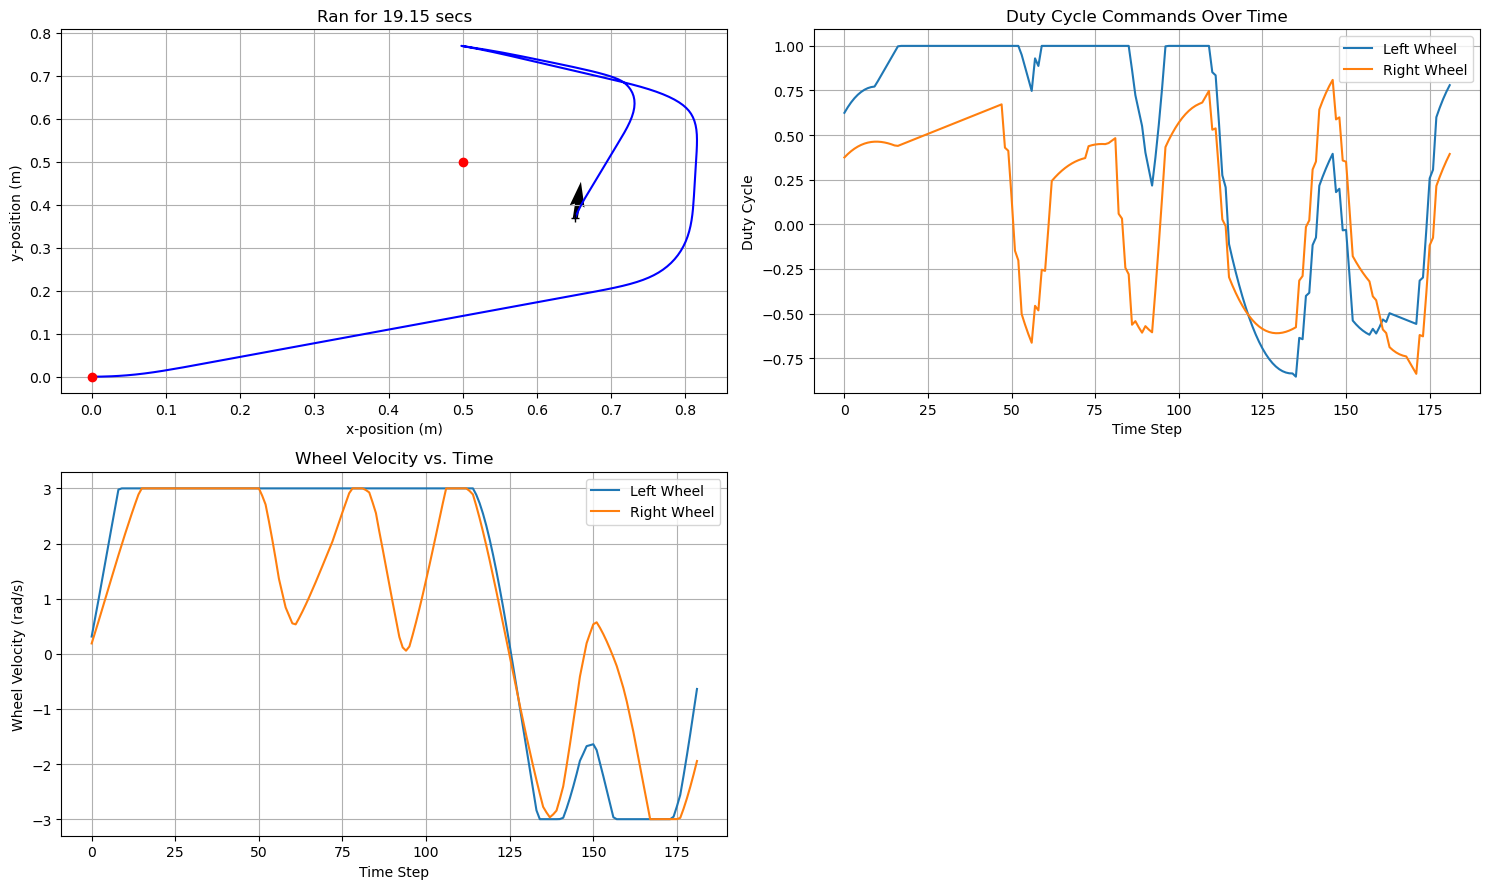

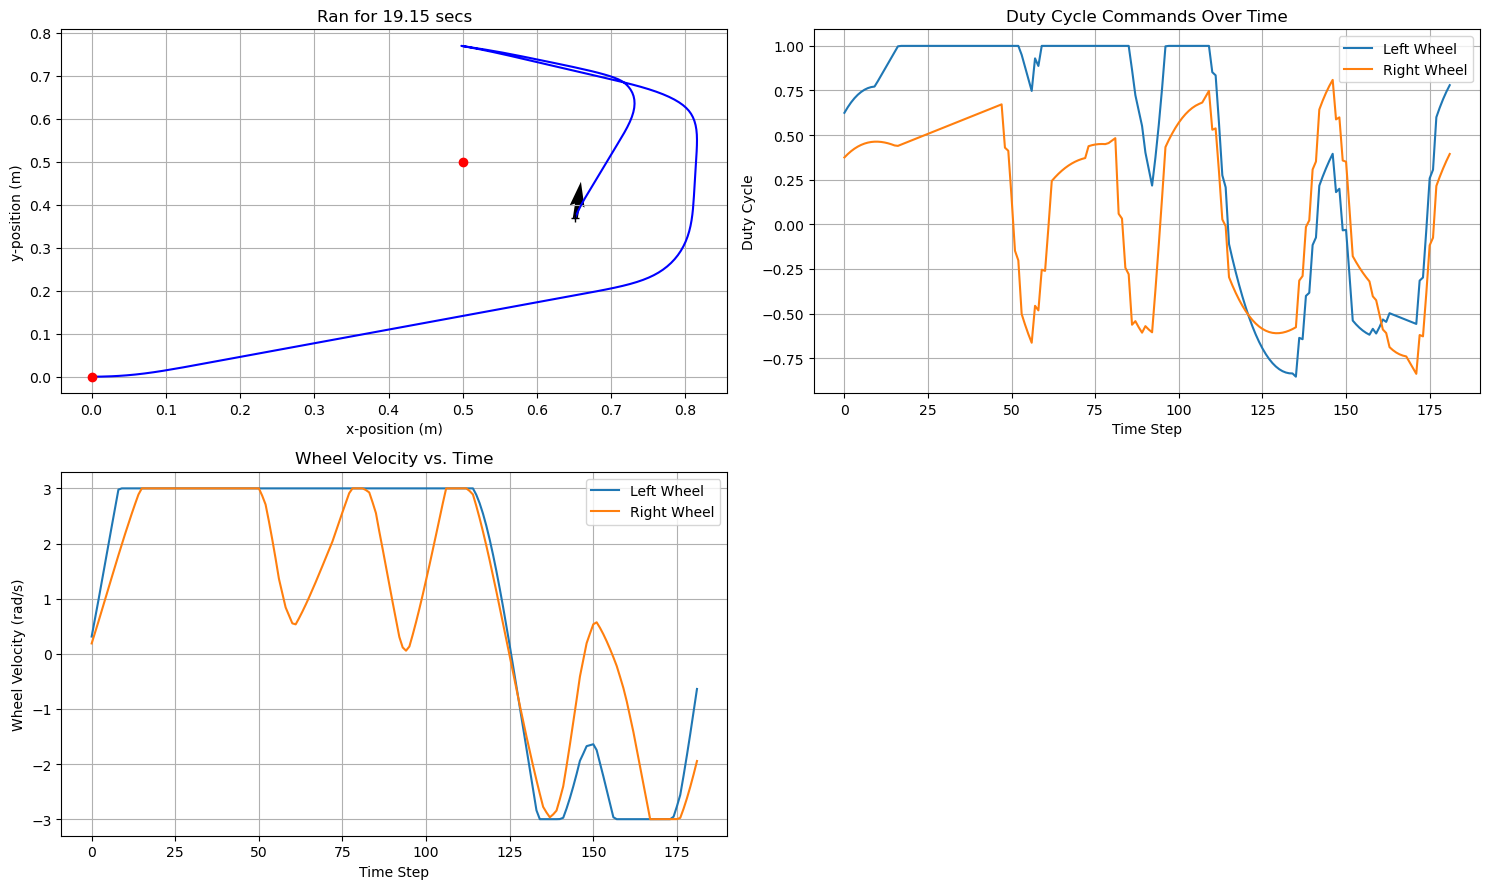

In [4]:
# Here are some example position commands we can put in.

# goal = (0.5, 0.5, 0)
goal = (0.5, 0.5, np.pi/2)
# goal = (0, 1, 0)
# goal = (1, 0, 0)




# Initialising controller, logging variables 
# Controller Parameters
controller = RobotController() # using default Kp = 8, Ki=9
planner = TentaclePlanner(max_linear_velocity=0.1, max_angular_velocity=0.5) # remember to paste in the class in the cell where I told you


robot.x = 0
robot.y = 0
robot.th = 0
robot.wl = 0
robot.wr = 0

poses = []
goal_positions = []
velocities = []
desired_velocities = []
duty_cycle_commands = []
error_sums = []
errors = []
actual_dts = []



try:
    goal_positions.append([0, 0, 0])
    goal_positions.append([goal[0],goal[1],goal[2]])
    start_time = time.time()
    while True: 
        inputs = planner.get_control_inputs(*goal, *robot.pose, strategy="tentacles")
        duty_cycle_l, duty_cycle_r = controller.drive(
                    inputs['linear_velocity'], 
                    inputs['angular_velocity'], 
                    robot.wl, 
                    robot.wr
                )
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r)
        display.clear_output(wait=True)


        
        # Log data
        # Here, I record and log everything so we can graph it.
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        # desired_velocities.append([wl_desired, wr_desired])
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")

    duration = time.time() - start_time

    # Plot robot data
#     display.clear_output(wait=True)
    fig = plt.figure(figsize=(15,9))
    
    plt.subplot(2, 2, 1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1], 'b', label='Robot Path')
    plt.plot(np.array(goal_positions)[:,0],np.array(goal_positions)[:,1],'ro', label='Goal Position')
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.title(f"Ran for {duration:.2f} secs")
#     plt.axis('equal')
    plt.grid()

    plt.subplot(2, 2, 2)
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
    
    plt.subplot(2, 2, 3)
    velocities = np.array(velocities)
    desired_velocities = np.array(desired_velocities)
    plt.plot(velocities[:, 0], label='Left Wheel')
    plt.plot(velocities[:, 1], label='Right Wheel')
    # plt.plot(desired_velocities[:, 0], label='Desired Left Wheel')
    # plt.plot(desired_velocities[:, 1], label='Desired Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Wheel Velocity (rad/s)')
    plt.title('Wheel Velocity vs. Time')
    plt.legend() 
    plt.grid()
   
        
    fig.tight_layout()

    display.display(plt.gcf())

#     GPIO.cleanup()

    """
    Hopefully the graphs are self explanatory. If not, please ask me. I'm happy to explain anything.
    """
